# Cipla Data Science Challenge on Hacker Earth (Loan Prediction)

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
# pd.get_option("display.max_rows")

In [3]:
train = pd.read_csv('train.csv')
train = train[train['Loan Sanction Amount (USD)'].notnull()]
train = train[train['Loan Sanction Amount (USD)']<200000]

test = pd.read_csv('test.csv')

print('train shape: ', train.shape)
train.head()

train shape:  (29368, 24)


,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,298.54,N,Y,2.0,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,NaN,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [4]:
# test.head()

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29368 entries, 0 to 29999
Data columns (total 24 columns):
Customer ID                    29368 non-null object
Name                           29368 non-null object
Gender                         29317 non-null object
Age                            29368 non-null int64
Income (USD)                   24921 non-null float64
Income Stability               27724 non-null object
Profession                     29368 non-null object
Type of Employment             22248 non-null object
Location                       29368 non-null object
Loan Amount Request (USD)      29368 non-null float64
Current Loan Expenses (USD)    29203 non-null float64
Expense Type 1                 29368 non-null object
Expense Type 2                 29368 non-null object
Dependents                     26956 non-null float64
Credit Score                   27714 non-null float64
No. of Defaults                29368 non-null int64
Has Active Credit Card         27878 non

In [6]:
# test.info()

In [7]:
# These two features in test data should be of type int and float, but it is of type object
# 1. Co-applicant
# 2. Property price

test['Co-Applicant'].replace('?', '1', inplace=True)

test['Co-Applicant'] = test['Co-Applicant'].apply(pd.to_numeric)

test['Property Price'].replace('?', float('NaN'), inplace=True)
test['Property Price'] = pd.to_numeric(test['Property Price'])

print(train.shape, test.shape)

(29368, 24) (20000, 23)


In [8]:
test.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price
0,C-26247,Tandra Olszewski,F,47,3472.69,Low,Commercial associate,Managers,Semi-Urban,137088.98,396.72,N,N,2.0,799.14,0,Unpossessed,843,3472.69,2,Urban,1,236644.50
1,C-35067,Jeannette Cha,F,57,1184.84,Low,Working,Sales staff,Rural,104771.59,463.76,Y,Y,2.0,833.31,0,Unpossessed,22,1184.84,1,Rural,1,142357.30
2,C-34590,Keva Godfrey,F,52,1266.27,Low,Working,NaN,Semi-Urban,176684.91,493.15,N,Y,3.0,627.44,0,Unpossessed,1,1266.27,1,Urban,1,300991.24
3,C-16668,Elva Sackett,M,65,1369.72,High,Pensioner,NaN,Rural,97009.18,446.15,N,Y,2.0,833.20,0,Inactive,730,1369.72,1,Semi-Urban,0,125612.10
4,C-12196,Sade Constable,F,60,1939.23,High,Pensioner,NaN,Urban,109980.00,370.10,N,N,NaN,NaN,0,NaN,356,1939.23,4,Semi-Urban,1,180908.00


In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,29368.0,40.095750,16.047346,18.00,25.0000,40.000,55.0000,65.00
Income (USD),24921.0,2609.226102,11369.560494,377.70,1645.3200,2206.680,3068.7700,1777460.21
Loan Amount Request (USD),29368.0,86699.322970,55755.641774,6048.24,41052.3325,74630.310,118102.9225,621497.82
Current Loan Expenses (USD),29203.0,395.547766,234.691623,-999.00,246.5600,372.680,515.3450,3018.15
Dependents,26956.0,2.254081,0.953390,1.00,2.0000,2.000,3.0000,14.00
Credit Score,27714.0,739.185103,72.011198,580.00,681.1500,738.870,798.2100,896.26
No. of Defaults,29368.0,0.194055,0.395478,0.00,0.0000,0.000,0.0000,1.00
Property ID,29368.0,501.810440,288.228525,1.00,251.0000,504.000,751.0000,999.00
Property Age,24658.0,2609.793491,11428.889551,377.70,1645.2000,2207.705,3070.9150,1777460.21
Property Type,29368.0,2.459105,1.118584,1.00,1.0000,2.000,3.0000,4.00


In [10]:
# Checking fo null values in train data
a = train.isnull().sum()
a[a>0]

Gender                           51
Income (USD)                   4447
Income Stability               1644
Type of Employment             7120
Current Loan Expenses (USD)     165
Dependents                     2412
Credit Score                   1654
Has Active Credit Card         1490
Property Age                   4710
Property Location               347
dtype: int64

In [11]:
# Checking fo null values in test data
a = test.isnull().sum()
a[a>0]

Gender                           31
Income (USD)                    750
Income Stability                813
Type of Employment             4689
Current Loan Expenses (USD)      83
Dependents                     1142
Credit Score                    743
Has Active Credit Card         1076
Property Age                    892
Property Location               160
Property Price                  168
dtype: int64

**Obsrvation:-** There are 11 features which are having missing values, Gender feature has 53 null values, Income (USD) feature has 4576 null values and so on.

In [12]:
# Finding all rows with missing values
train[train.isnull().any(axis=1)]

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,298.54,N,Y,2.0,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,NaN,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28
7,C-11006,Clarinda Montana,F,45,NaN,Low,State servant,Managers,Semi-Urban,240311.77,807.64,N,N,2.0,812.26,0,Active,314,NaN,2,Urban,1,401040.70,168218.24
11,C-37677,Xenia Browder,F,39,2719.74,Low,Commercial associate,High skill tech staff,Semi-Urban,20879.96,93.99,Y,N,2.0,646.21,0,NaN,196,2719.74,2,Rural,0,33568.47,0.00
12,C-30073,Brinda Vaz,F,48,777.25,Low,Working,NaN,Semi-Urban,96080.60,342.33,N,N,3.0,764.11,0,Active,678,777.25,1,Semi-Urban,1,146073.26,67256.42
13,C-34993,Brendon Swanson,F,43,997.25,Low,Working,NaN,Rural,48894.06,178.06,Y,N,1.0,726.28,0,NaN,578,997.25,4,Rural,1,80607.40,34225.84
18,C-11119,Sachiko Sheilds,M,65,1523.03,High,Pensioner,NaN,Semi-Urban,66567.35,299.53,Y,Y,3.0,862.33,0,Unpossessed,739,1523.03,4,Semi-Urban,0,118617.77,46597.14


**Observation:-** 14439 row are having missing values, almost half of the table rows has missing values

# Exploratory Data Analysis

### 1. Analysing 'Customer ID' feature

In [13]:
train['Customer ID'].nunique()

# it is a unique id number

29368

### 2. Analysing 'Name' feature

In [14]:
train['Name'].nunique()
# it is unique name of the person

29368

In [15]:
def bar_plot(feat):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    ax = train[feat].value_counts().plot(kind='bar');
    plt.xlabel(feat)
    plt.title('Train -> bar plot of '+feat)
    plt.grid()

    plt.subplot(1,2,2)
    ax = test[feat].value_counts().plot(kind='bar');
    plt.xlabel(feat)
    plt.title('Test -> bar plot of '+feat)
    plt.grid()
    
def kde_plot(feat):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    ax = train[feat].plot(kind='kde');
    plt.xlabel(feat)
    plt.title('Train -> KDE plot of '+feat)
    plt.grid()

    plt.subplot(1,2,2)
    ax = test[feat].plot(kind='kde');
    plt.xlabel(feat)
    plt.title('Test -> KDE plot of '+feat)
    plt.grid()
    
def box_plot(feat):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.boxplot(y=feat, data=train)
    plt.xlabel(feat)
    plt.title('Train -> Box plot of '+feat);

    plt.subplot(1,2,2)
    sns.boxplot(y=feat, data=test)
    plt.xlabel(feat)
    plt.title('Test -> Box plot of '+feat);

### 3. Analysing "Gender" feature
- There are 53 missing values in Gender column
- It is categorical data

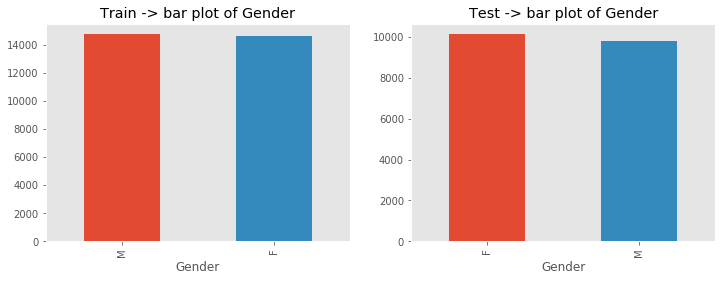

In [820]:
bar_plot('Gender')

### 4. Analyzing 'Age' feature

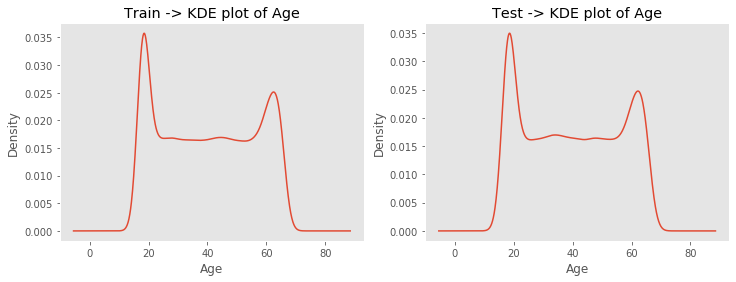

In [821]:
kde_plot('Age')

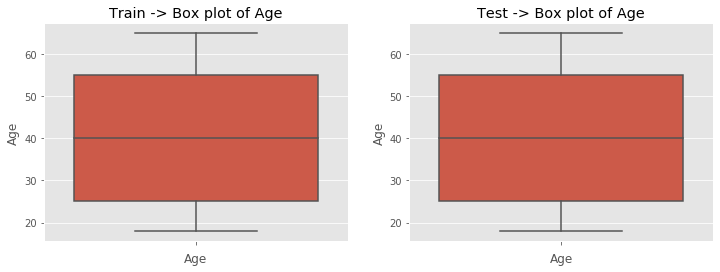

In [822]:
box_plot('Age')

### 5. Analysing "Income (USD)" column
- There are 4576 minssing values
- It is a numerical data

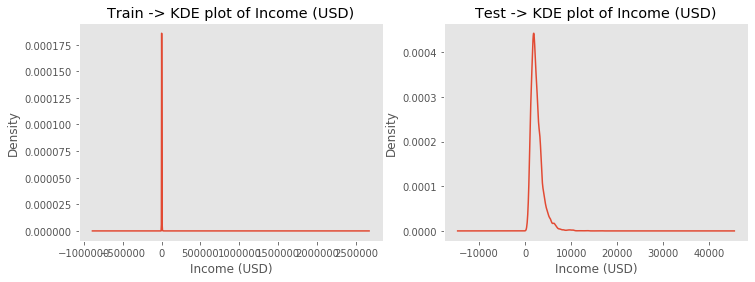

In [823]:
kde_plot('Income (USD)')

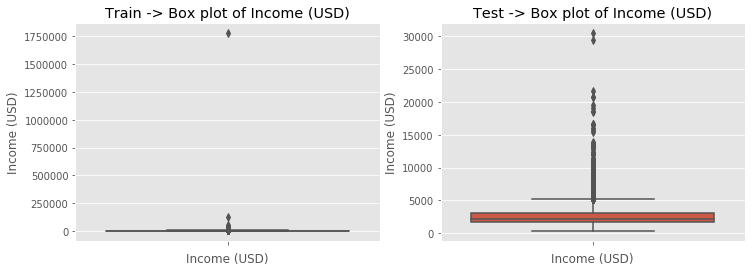

In [824]:
box_plot('Income (USD)')

**Observation:-** 'Income (USD)' can be highly affected by outlier

In [825]:
arr = train[train['Income (USD)'].notnull()]['Income (USD)']
for i in range(11):
    print('{} %\t  {}'.format(90+i, np.percentile(arr, 90+i)))

90 %	  4127.13
91 %	  4225.368
92 %	  4374.006000000001
93 %	  4562.140000000001
94 %	  4794.038
95 %	  4977.51
96 %	  5290.1500000000015
97 %	  5630.1939999999995
98 %	  6268.823999999998
99 %	  7174.594
100 %	  1777460.21


- since 99% of data are < 7425, so taking only 99% of data

### 6. Analysing "Income Stability" column
- There are 1683 missing values
- Is is categorical data

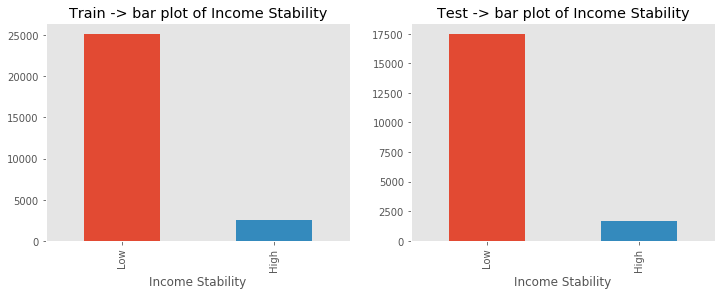

In [826]:
bar_plot('Income Stability')

- Income Stability can be considered as Ordinal Categorical feature

### 7. Analysing 'Profession' feature

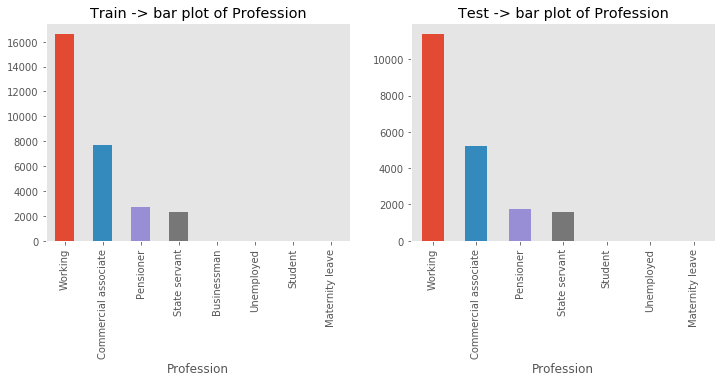

In [828]:
bar_plot('Profession')

### 9. Analysing "Type of Employment" Column
- It has 7270 missing values
- It is categorical data

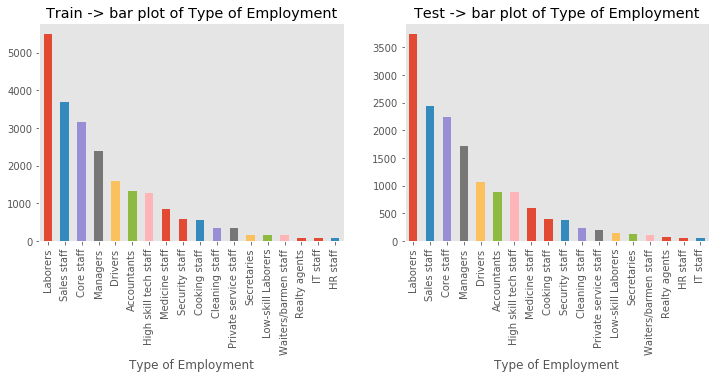

In [829]:
bar_plot('Type of Employment')

### 10. Analysing 'Location' feature
- it is categorical feature

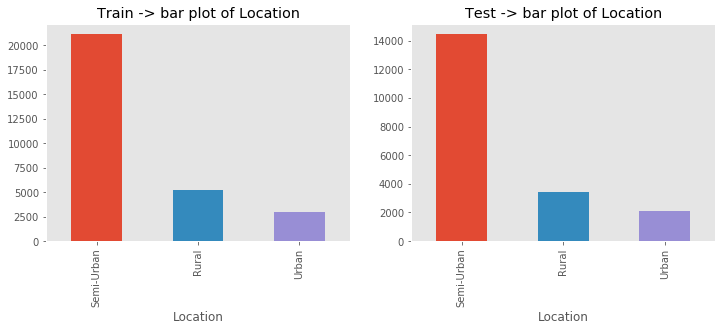

In [830]:
bar_plot('Location')

### 11. Analysing 'Loan Amount Request (USD)' feature

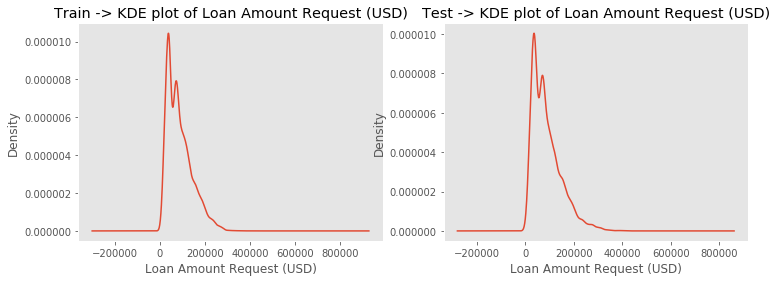

In [831]:
kde_plot('Loan Amount Request (USD)')

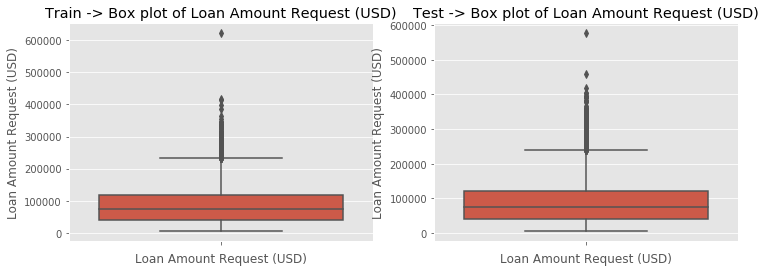

In [832]:
box_plot('Loan Amount Request (USD)')

In [833]:
arr = train[train['Loan Amount Request (USD)'].notnull()]['Loan Amount Request (USD)']
for i in range(11):
    print('{} %\t  {}'.format(90+i, np.percentile(arr, 90+i)))

90 %	  167256.15
91 %	  172591.5074
92 %	  177450.54559999995
93 %	  183251.72290000005
94 %	  189227.1918
95 %	  196241.9305
96 %	  203961.44559999998
97 %	  215643.06489999982
98 %	  230572.902
99 %	  249508.49609999973
100 %	  621497.82


### 12. Analysing "Current Loan Expenses (USD)" column
- it has 172 missing values
- it is numerical data

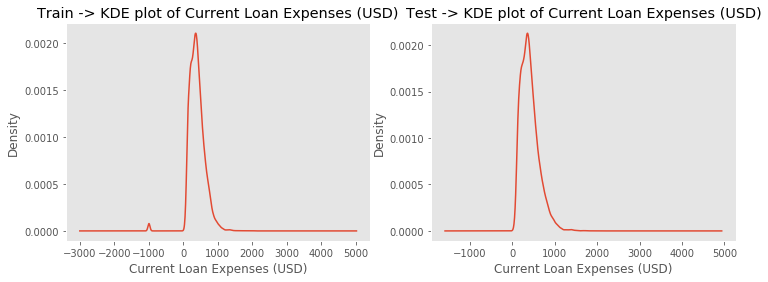

In [834]:
kde_plot('Current Loan Expenses (USD)')

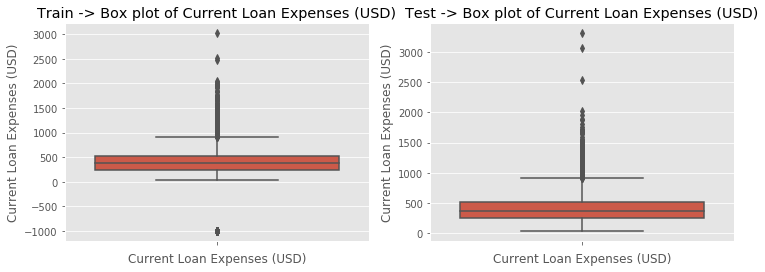

In [835]:
box_plot('Current Loan Expenses (USD)')

**Observtion:-** value ranges betwee 0 and 500, and there are some outliers

In [836]:
arr = train[train['Current Loan Expenses (USD)'].notnull()]['Current Loan Expenses (USD)']
for i in range(11):
    print('{} %\t  {}'.format(90+i, np.percentile(arr, 90+i)))

90 %	  677.51
91 %	  695.96
92 %	  714.0283999999999
93 %	  732.7986
94 %	  754.8152
95 %	  780.4239999999999
96 %	  809.1683999999999
97 %	  854.6709999999997
98 %	  919.3395999999998
99 %	  1025.6372
100 %	  3018.15


In [837]:
# since 99% of data are < 1034, so taking only 99% of data, and removing negative value

### 13. Analysing 'Expense Type 1' feature

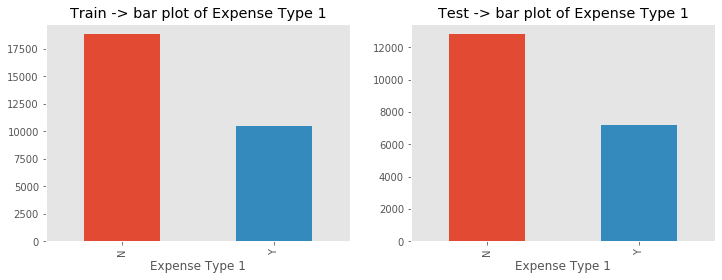

In [838]:
bar_plot('Expense Type 1')

### 14. Analysing 'Expense Type 2' feature

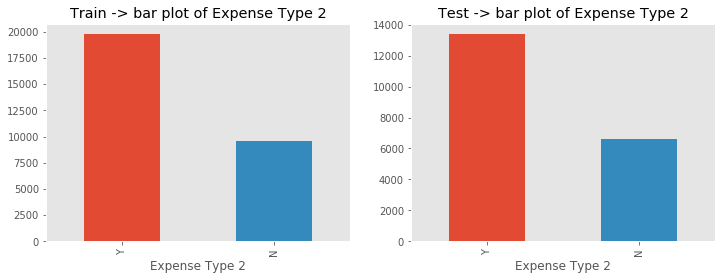

In [839]:
bar_plot('Expense Type 2')

### 15. Analysing "Dependents" data
- it is numerical data
- it has 2493 missing values

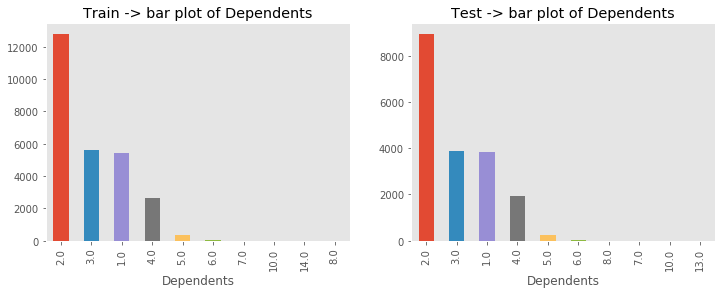

In [840]:
bar_plot('Dependents')

**Observation:-** most of the person has two dependents

### 16. Analysing "Credit Score" column
- it has 1703 missing values
- it is numerical data

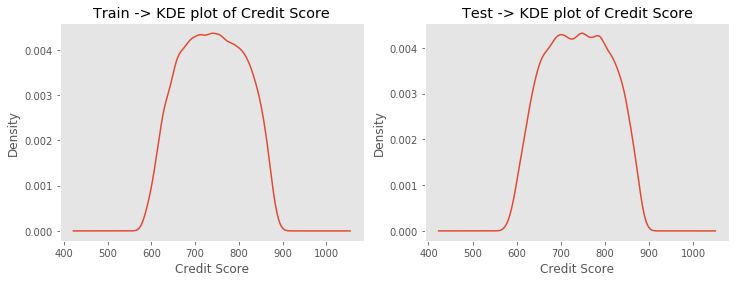

In [841]:
kde_plot('Credit Score')

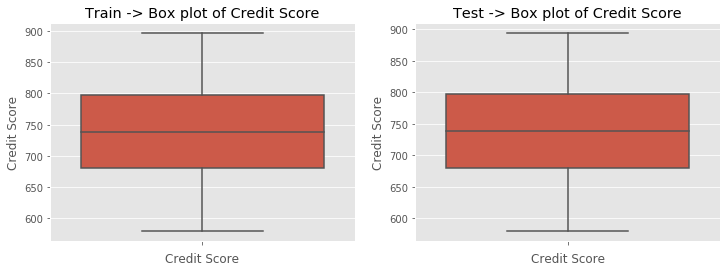

In [842]:
box_plot('Credit Score')

**Observation:-** almost no outlier

### 17. Analysing 'No. of Defaults' feature

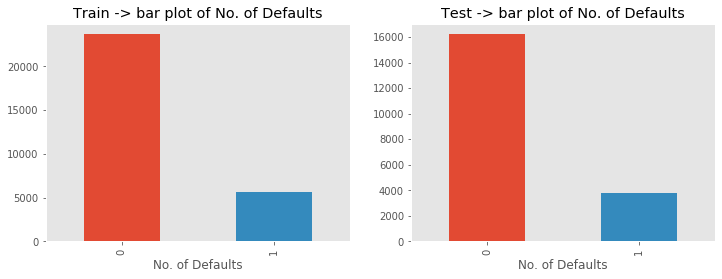

In [843]:
bar_plot('No. of Defaults')

### 18. Analysing "Has Active Credit Card" column
- it has 1566 missing values
- it is categorical data

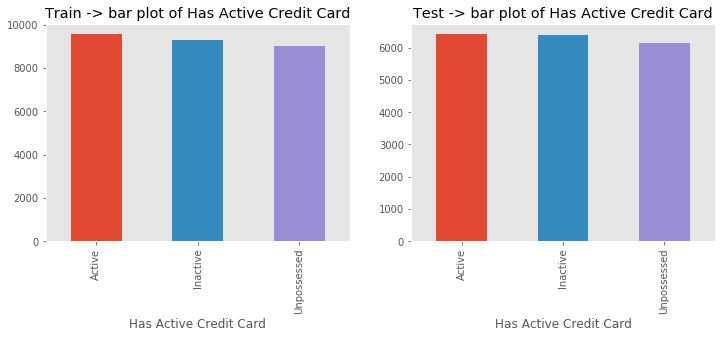

In [844]:
bar_plot('Has Active Credit Card')

### 19. Analysing 'Property ID' feature

In [845]:
train['Property ID'].nunique()

999

### 20. Analysing "Property Age" column
- it has 4850 missing values
- it is numerical data

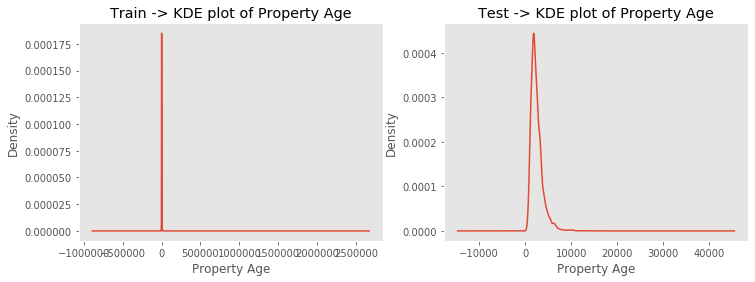

In [846]:
kde_plot('Property Age')

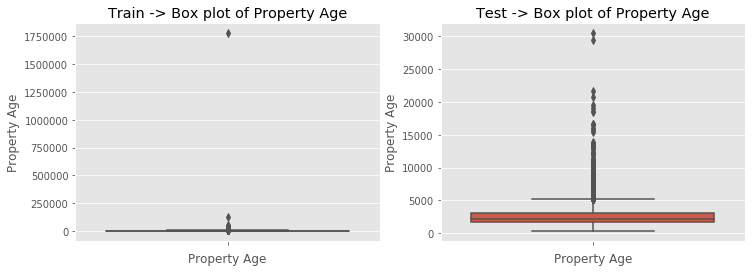

In [712]:
box_plot('Property Age')

**Observation:-** it has outlier

In [713]:
arr = train[train['Property Age'].notnull()]['Property Age']
for i in range(11):
    print('{} %\t  {}'.format(90+i, np.percentile(arr, 90+i)))

90 %	  4126.673999999999
91 %	  4225.1410000000005
92 %	  4372.826800000004
93 %	  4559.359400000004
94 %	  4792.3553999999995
95 %	  4969.5374999999985
96 %	  5280.988799999999
97 %	  5625.396700000001
98 %	  6252.768000000001
99 %	  7108.4759
100 %	  1777460.21


- since 99% of data are < 7394, so taking only 99% of data

### 21. Analysing 'Property Type' feature

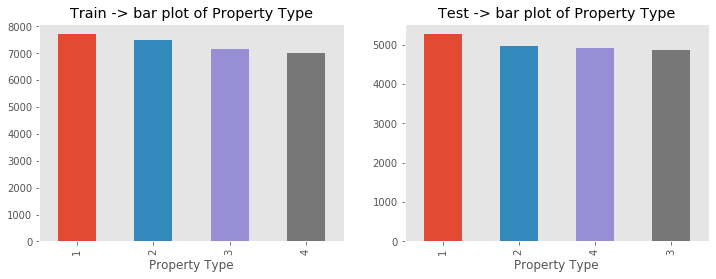

In [714]:
bar_plot('Property Type')

### 22. Analysing "Property Location" column
- it has 356 missing values
- it is categorical data

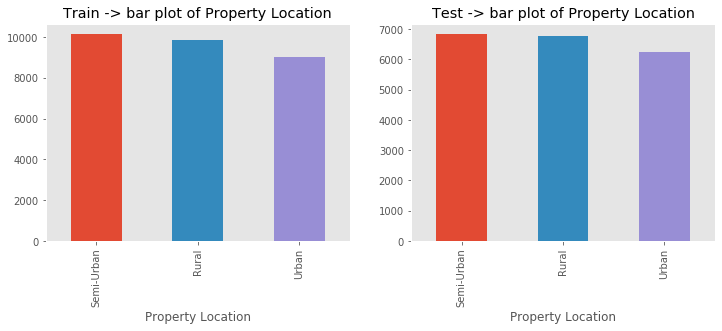

In [715]:
bar_plot('Property Location')

### 23. Analysing 'Co-Applicant' feature

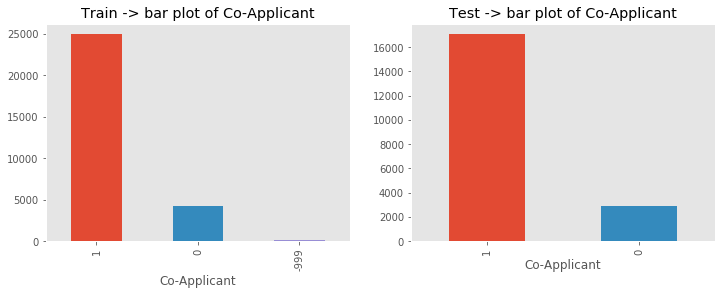

In [716]:
bar_plot('Co-Applicant')

In [717]:
train['Co-Applicant'].value_counts()

 1      24945
 0       4260
-999      163
Name: Co-Applicant, dtype: int64

- since -999 value seems to be erronuous, so removing this value

### 24. Analsing 'Property Price' feature

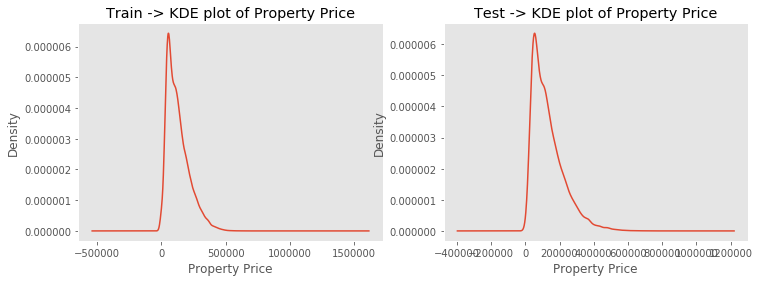

In [718]:
kde_plot('Property Price')

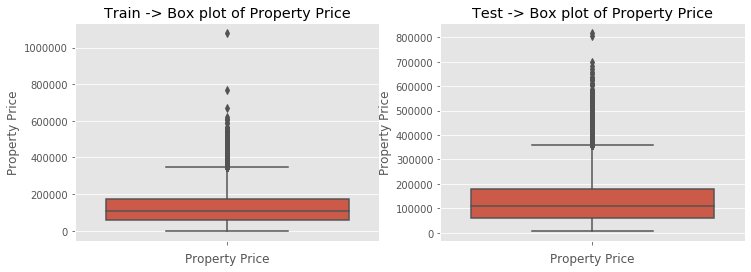

In [719]:
box_plot('Property Price')

### 25. Analysing "Loan Sanction Amount (USD)" column
- it has 340 missing values
- it is numercal data

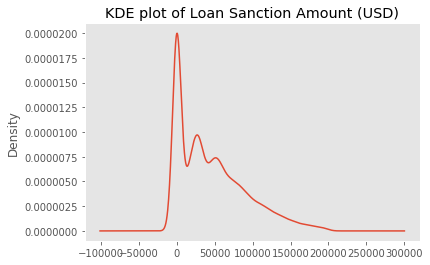

In [720]:
ax = train['Loan Sanction Amount (USD)'].plot(kind='kde');
plt.title('KDE plot of Loan Sanction Amount (USD)')
plt.grid()

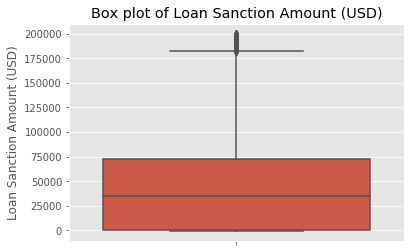

In [721]:
sns.boxplot(y='Loan Sanction Amount (USD)', data=train)
plt.title('Box plot of Loan Sanction Amount (USD)');

**Observatioin:-** it has outlier

In [722]:
arr = train[train['Loan Sanction Amount (USD)'].notnull()]['Loan Sanction Amount (USD)']
for i in range(11):
    print('{} %\t  {}'.format(90+i, np.percentile(arr, 90+i)))

90 %	  111679.39799999999
91 %	  115398.5461
92 %	  119484.9196
93 %	  124069.9850000001
94 %	  129438.4092
95 %	  134983.17449999996
96 %	  141733.728
97 %	  150280.0026999999
98 %	  160368.1008
99 %	  175601.68639999998
100 %	  199867.8


# Imputing missing vaues

### imputing Numerical feature by it Median

In [16]:
def inpute_numerical(tr, te):
    tr['Income (USD)'].fillna(value=tr['Income (USD)'].median(), inplace=True)
    tr = tr[tr['Income (USD)']<7425]
    te['Income (USD)'].fillna(value=tr['Income (USD)'].median(), inplace=True)
    
    tr['Loan Amount Request (USD)'].fillna(value=tr['Loan Amount Request (USD)'].median(), inplace=True)
    tr = tr[tr['Loan Amount Request (USD)']<400000]
    te['Loan Amount Request (USD)'].fillna(value=tr['Loan Amount Request (USD)'].median(), inplace=True)
    
    tr['Current Loan Expenses (USD)'].fillna(value=tr['Current Loan Expenses (USD)'].median(), inplace=True)
    tr = tr[tr['Current Loan Expenses (USD)']<1034]
    tr = tr[tr['Current Loan Expenses (USD)']>0]
    te['Current Loan Expenses (USD)'].fillna(value=tr['Current Loan Expenses (USD)'].median(), inplace=True)
    
    tr['Dependents'].fillna(value=2, inplace=True)
    te['Dependents'].fillna(value=2, inplace=True)
    
    tr['Property Price'].fillna(value=tr['Property Price'].median(), inplace=True)
    te['Property Price'].fillna(value=tr['Property Price'].median(), inplace=True)

    tr['Credit Score'].fillna(value=tr['Credit Score'].median(), inplace=True)
    te['Credit Score'].fillna(value=tr['Credit Score'].median(), inplace=True)
    
    tr['Property Age'].fillna(value=tr['Property Age'].median(), inplace=True)
    tr = tr[tr['Property Age']<7394]
    te['Property Age'].fillna(value=tr['Property Age'].median(), inplace=True)
    
    tr.replace({'Low':0, 'High':1}, inplace=True)
    te.replace({'Low':0, 'High':1}, inplace=True)
    
    return tr, te

In [17]:
train, test = inpute_numerical(train, test)

print(train.shape)
print(test.shape)

C:\Users\nehal\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(28713, 24)
(20000, 23)


### Let's impute Categorical columns by KNNClassifier

In [18]:
def categorical_impute(tr, te, feature, target):
#     here target is the variable which is to be imputed
    data_X = tr[feature]
    data_X = pd.get_dummies(data_X)
    
    data_y = tr[target]
    data = pd.concat([data_X, data_y], axis=1)
    
    # dividing data into train and test
    train_gender = data[data[target].notnull()]
    test_gender = data[data[target].isnull()]
    
    # seperating source and target data
    y_train_g = train_gender[target]
    X_train_g = train_gender.drop([target], axis=1)
    
    y_test_g = test_gender[[target]]
    X_test_g = test_gender.drop([target], axis=1)
    
    # standardizing the data
    scaler = StandardScaler()
    X_train_g = scaler.fit_transform(X_train_g)
    X_test_g = scaler.transform(X_test_g)

    # preparing KNN model with 3 neighbour
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train_g, y_train_g)
    predicted = neigh.predict(X_test_g)
    
    y_test_g[target] = predicted
    indexs = y_test_g.index
    
    tr.loc[indexs, target] = y_test_g[target]
    
    # =========imputing test data===============
    data_X = te[feature]
    data_X = pd.get_dummies(data_X)
    
    data_y = te[target]
    data = pd.concat([data_X, data_y], axis=1)
    
    test_gender = data[data[target].isnull()]
    
    # seperating source and target data
    y_test_g = test_gender[[target]]
    X_test_g = test_gender.drop([target], axis=1)
    
    X_test_g = scaler.transform(X_test_g)

    predicted = neigh.predict(X_test_g)
    
    y_test_g[target] = predicted
    indexs = y_test_g.index
    
    te.loc[indexs, target] = y_test_g[target]
    
    return tr, te

In [19]:
# Now these features have no null values
feature = ['Age', 'Income (USD)', 'Profession', 'Location', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 
              'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score', 'No. of Defaults', 'Property Age', 
              'Property Type', 'Property Price']


In [20]:
train, test = categorical_impute(train, test, feature, 'Gender')
train, test = categorical_impute(train, test, feature, 'Income Stability')
train, test = categorical_impute(train, test, feature, 'Type of Employment')
train, test = categorical_impute(train, test, feature, 'Has Active Credit Card')
train, test = categorical_impute(train, test, feature, 'Property Location')


C:\Users\nehal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nehal\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\nehal\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
C:\Users\nehal\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\nehal\Anacon

In [21]:
train.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,0.0,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,Active,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,0.0,Working,Managers,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,1.0,Pensioner,High skill tech staff,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,2206.68,1.0,Pensioner,Drivers,Rural,80057.92,298.54,N,Y,2.0,832.70,1,Unpossessed,890,2181.94,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,0.0,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,2.0,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [22]:
y = train[['Loan Sanction Amount (USD)']]
X = train.drop(['Customer ID', 'Name', 'Loan Sanction Amount (USD)'], axis=1)

test = test.drop(['Customer ID', 'Name'], axis=1)

X = pd.get_dummies(X)
test = pd.get_dummies(test)

print(X.shape, test.shape)

(28713, 53) (20000, 53)


In [23]:
# X.to_csv('final_X.csv', index=False)
# y.to_csv('final_y.csv', index=False)
# test.to_csv('final_test.csv', index=False)

In [24]:
cols = X.columns
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=103)

print('train shape: ', X_train.shape, y_train.shape)
print('cv shape: ', X_cv.shape, y_cv.shape)

train shape:  (22970, 53) (22970, 1)
cv shape:  (5743, 53) (5743, 1)


In [25]:
X_train.head()

,Age,Income (USD),Income Stability,Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Gender_F,Gender_M,Profession_Businessman,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Student,Profession_Unemployed,Profession_Working,Type of Employment_Accountants,Type of Employment_Cleaning staff,Type of Employment_Cooking staff,Type of Employment_Core staff,Type of Employment_Drivers,Type of Employment_HR staff,Type of Employment_High skill tech staff,Type of Employment_IT staff,Type of Employment_Laborers,Type of Employment_Low-skill Laborers,Type of Employment_Managers,Type of Employment_Medicine staff,Type of Employment_Private service staff,Type of Employment_Realty agents,Type of Employment_Sales staff,Type of Employment_Secretaries,Type of Employment_Security staff,Type of Employment_Waiters/barmen staff,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,Expense Type 1_Y,Expense Type 2_N,Expense Type 2_Y,Has Active Credit Card_Active,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban
25903,39,3381.93,0.0,157397.63,427.61,3.0,861.58,1,531,3381.93,4,1,292712.97,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0
8014,41,2043.53,0.0,70422.76,486.54,2.0,718.66,0,926,2043.53,2,1,88805.60,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1
4220,48,1157.25,0.0,8452.77,87.98,3.0,804.06,0,622,1157.25,3,1,12788.97,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0
22512,64,2302.11,0.0,57314.47,382.73,4.0,772.61,0,504,2302.11,1,1,94594.95,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0
7554,63,1709.37,0.0,38086.59,296.18,1.0,773.42,0,270,1709.37,2,0,59943.69,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0


In [26]:
# y_train.head()

### Scaling the features

In [27]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_cv = scaler.transform(X_cv)
test = scaler.transform(test)

C:\Users\nehal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nehal\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\nehal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\nehal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


# ============================================================

##### score = max(0, 100*metrics(r2_score(actual, predicted)))

### Cat Boost Regressor

In [42]:
cboost_reg = CatBoostRegressor( task_type='GPU', logging_level='Silent')

parameters = {'depth' : [4,5,6,7,8,9,10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'iterations' : [50,60,70,80,90, 100,300,500]
              }

cboost_grid = GridSearchCV(cboost_reg, param_grid=parameters, cv=5, scoring='r2')

cboost_grid.fit(X_train, y_train,)


print('CatBoost R2 Score is: ', r2_score(y_cv, cboost_grid.predict(X_cv)))

CatBoost R2 Score is:  0.7592693852866386


In [47]:
# best hyper parameter after greid search
cboost_grid.best_params_

{'depth': 8, 'iterations': 500, 'learning_rate': 0.03}

In [76]:
# let's again train the model, using only best hyperparameters
cboost_reg = CatBoostRegressor(iterations=500, 
                               depth=8,
                               learning_rate=0.03,
                               task_type='GPU', 
                               use_best_model=True,
#                                logging_level='Silent'
                              )


cboost_reg.fit(X_train, y_train,
              eval_set=(X_cv, y_cv)
              )


print('CatBoost R2 Score is: ', r2_score(y_cv, cboost_reg.predict(X_cv)))

0:	learn: 61147.5673387	test: 63051.3561344	best: 63051.3561344 (0)	total: 82ms	remaining: 40.9s
1:	learn: 59621.6711532	test: 61484.2925841	best: 61484.2925841 (1)	total: 163ms	remaining: 40.6s
2:	learn: 58154.9910706	test: 59974.3297501	best: 59974.3297501 (2)	total: 239ms	remaining: 39.5s
3:	learn: 56719.7733878	test: 58498.7427988	best: 58498.7427988 (3)	total: 319ms	remaining: 39.6s
4:	learn: 55326.6921642	test: 57071.1218888	best: 57071.1218888 (4)	total: 401ms	remaining: 39.7s
5:	learn: 53987.8889224	test: 55696.1555104	best: 55696.1555104 (5)	total: 481ms	remaining: 39.6s
6:	learn: 52695.4615182	test: 54368.1787645	best: 54368.1787645 (6)	total: 564ms	remaining: 39.7s
7:	learn: 51444.9653503	test: 53089.3594181	best: 53089.3594181 (7)	total: 647ms	remaining: 39.8s
8:	learn: 50242.0902811	test: 51857.4420506	best: 51857.4420506 (8)	total: 728ms	remaining: 39.7s
9:	learn: 49077.8225359	test: 50660.5107632	best: 50660.5107632 (9)	total: 812ms	remaining: 39.8s
10:	learn: 47961.6752

84:	learn: 22357.4932191	test: 23095.8830400	best: 23095.8830400 (84)	total: 6.91s	remaining: 33.7s
85:	learn: 22313.5653934	test: 23050.3888200	best: 23050.3888200 (85)	total: 7s	remaining: 33.7s
86:	learn: 22278.6515300	test: 23012.1181730	best: 23012.1181730 (86)	total: 7.08s	remaining: 33.6s
87:	learn: 22239.2834129	test: 22971.8137113	best: 22971.8137113 (87)	total: 7.17s	remaining: 33.6s
88:	learn: 22204.0625773	test: 22936.8540164	best: 22936.8540164 (88)	total: 7.24s	remaining: 33.5s
89:	learn: 22168.8887438	test: 22898.5969434	best: 22898.5969434 (89)	total: 7.33s	remaining: 33.4s
90:	learn: 22141.4908541	test: 22869.6914910	best: 22869.6914910 (90)	total: 7.42s	remaining: 33.4s
91:	learn: 22111.9987641	test: 22838.7469351	best: 22838.7469351 (91)	total: 7.5s	remaining: 33.3s
92:	learn: 22085.2465182	test: 22808.5609126	best: 22808.5609126 (92)	total: 7.58s	remaining: 33.2s
93:	learn: 22063.1466592	test: 22783.6877154	best: 22783.6877154 (93)	total: 7.66s	remaining: 33.1s
94:	

165:	learn: 21353.0865709	test: 22205.1414439	best: 22205.1414439 (165)	total: 13.2s	remaining: 26.6s
166:	learn: 21347.4087420	test: 22200.3574487	best: 22200.3574487 (166)	total: 13.3s	remaining: 26.6s
167:	learn: 21345.5621333	test: 22199.0559086	best: 22199.0559086 (167)	total: 13.4s	remaining: 26.5s
168:	learn: 21336.9043589	test: 22196.8433208	best: 22196.8433208 (168)	total: 13.5s	remaining: 26.4s
169:	learn: 21335.9704570	test: 22196.3734259	best: 22196.3734259 (169)	total: 13.5s	remaining: 26.3s
170:	learn: 21331.7871874	test: 22196.2983652	best: 22196.2983652 (170)	total: 13.6s	remaining: 26.2s
171:	learn: 21329.3720723	test: 22195.6886160	best: 22195.6886160 (171)	total: 13.7s	remaining: 26.1s
172:	learn: 21317.9069786	test: 22193.2803030	best: 22193.2803030 (172)	total: 13.8s	remaining: 26s
173:	learn: 21316.7730861	test: 22192.5604319	best: 22192.5604319 (173)	total: 13.8s	remaining: 25.9s
174:	learn: 21314.8435101	test: 22191.1051928	best: 22191.1051928 (174)	total: 13.9s

249:	learn: 21078.8516870	test: 22118.5565108	best: 22115.9137987 (243)	total: 18.9s	remaining: 18.9s
250:	learn: 21078.8116221	test: 22118.5668292	best: 22115.9137987 (243)	total: 19s	remaining: 18.8s
251:	learn: 21074.4733335	test: 22115.7208198	best: 22115.7208198 (251)	total: 19.1s	remaining: 18.8s
252:	learn: 21073.8310697	test: 22115.5453830	best: 22115.5453830 (252)	total: 19.1s	remaining: 18.7s
253:	learn: 21063.9314479	test: 22116.1748850	best: 22115.5453830 (252)	total: 19.2s	remaining: 18.6s
254:	learn: 21042.8730512	test: 22115.4927517	best: 22115.4927517 (254)	total: 19.3s	remaining: 18.5s
255:	learn: 21042.8199015	test: 22115.4174165	best: 22115.4174165 (255)	total: 19.4s	remaining: 18.4s
256:	learn: 21042.7461426	test: 22115.4298004	best: 22115.4174165 (255)	total: 19.4s	remaining: 18.4s
257:	learn: 21042.0812158	test: 22115.0335125	best: 22115.0335125 (257)	total: 19.5s	remaining: 18.3s
258:	learn: 21028.4113917	test: 22116.1625015	best: 22115.0335125 (257)	total: 19.6s

331:	learn: 20741.0114671	test: 22076.2310193	best: 22076.2310193 (331)	total: 24.6s	remaining: 12.5s
332:	learn: 20731.4615736	test: 22080.0444629	best: 22076.2310193 (331)	total: 24.7s	remaining: 12.4s
333:	learn: 20731.4252412	test: 22080.0982124	best: 22076.2310193 (331)	total: 24.8s	remaining: 12.3s
334:	learn: 20730.5763676	test: 22079.4046277	best: 22076.2310193 (331)	total: 24.9s	remaining: 12.2s
335:	learn: 20730.0864053	test: 22079.1989256	best: 22076.2310193 (331)	total: 24.9s	remaining: 12.2s
336:	learn: 20724.5308538	test: 22079.0428387	best: 22076.2310193 (331)	total: 25s	remaining: 12.1s
337:	learn: 20718.5320493	test: 22076.9588187	best: 22076.2310193 (331)	total: 25.1s	remaining: 12s
338:	learn: 20718.4989993	test: 22076.9495146	best: 22076.2310193 (331)	total: 25.2s	remaining: 11.9s
339:	learn: 20717.7201055	test: 22076.6776263	best: 22076.2310193 (331)	total: 25.2s	remaining: 11.9s
340:	learn: 20717.6903594	test: 22076.7365530	best: 22076.2310193 (331)	total: 25.3s	r

415:	learn: 20561.7368309	test: 22050.1653600	best: 22050.1653600 (415)	total: 30.5s	remaining: 6.17s
416:	learn: 20557.3349447	test: 22048.1955812	best: 22048.1955812 (416)	total: 30.6s	remaining: 6.09s
417:	learn: 20549.0370746	test: 22049.8703701	best: 22048.1955812 (416)	total: 30.7s	remaining: 6.02s
418:	learn: 20543.4358952	test: 22048.5868597	best: 22048.1955812 (416)	total: 30.8s	remaining: 5.95s
419:	learn: 20541.0169845	test: 22046.0134033	best: 22046.0134033 (419)	total: 30.9s	remaining: 5.88s
420:	learn: 20534.1820500	test: 22046.2225208	best: 22046.0134033 (419)	total: 30.9s	remaining: 5.8s
421:	learn: 20533.0259988	test: 22045.9533593	best: 22045.9533593 (421)	total: 31s	remaining: 5.73s
422:	learn: 20532.5735649	test: 22045.4253791	best: 22045.4253791 (422)	total: 31.1s	remaining: 5.66s
423:	learn: 20532.5546669	test: 22045.5113062	best: 22045.4253791 (422)	total: 31.1s	remaining: 5.58s
424:	learn: 20526.8455786	test: 22046.5455102	best: 22045.4253791 (422)	total: 31.2s	

497:	learn: 20383.1015131	test: 22048.5206120	best: 22041.3988557 (450)	total: 36.3s	remaining: 146ms
498:	learn: 20383.0208877	test: 22048.4978393	best: 22041.3988557 (450)	total: 36.3s	remaining: 72.8ms
499:	learn: 20379.8191287	test: 22048.6976172	best: 22041.3988557 (450)	total: 36.4s	remaining: 0us
bestTest = 22041.39886
bestIteration = 450
Shrink model to first 451 iterations.
CatBoost R2 Score is:  0.7594287278338274


In [77]:
test2 = pd.read_csv('test.csv')
test2 = test2[['Customer ID']]
test2['Loan Sanction Amount (USD)'] = cboost_reg.predict(test)
test2.to_csv('CBoostgridsearch1.csv', index=False)
test2.head()

,Customer ID,Loan Sanction Amount (USD)
0,C-26247,88990.948062
1,C-35067,64668.863519
2,C-34590,-2720.516402
3,C-16668,51275.499290
4,C-12196,66462.608621


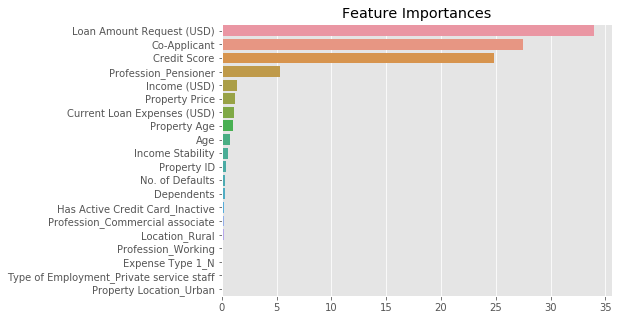

In [78]:
features = cols
importances = cboost_reg.feature_importances_
indices = (np.argsort(importances))

impf = 20
best_features = features[indices[-impf:][::-1]]
best_importances = importances[indices[-impf:][::-1]]

plt.figure(figsize=(7, impf//3.5))
plt.title('Feature Importances')

sns.barplot(x=best_importances, y=best_features);